In [1]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

from tools import *
from fit_funcs import *
from entropy import *
import costfun.costfun as cost
import utils.figures as fig_help
from RandomMatrixTheory import goe
import utils.tools as tools

import importlib as imp
def reload_modules():
    imp.reload(cost)
    imp.reload(fig_help)

import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}

%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:200])
colors_ls_cyc = itertools.cycle(colors_ls)

markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

linestyle_ls = ['-','--',':', '-.']
linestyle = itertools.cycle(linestyle_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists


config_disorder = 0
config_disorder_sorted = 0

if config_disorder and config_disorder_sorted:
    base_dir = "../results_conf_dis_sort/PBC/"
elif config_disorder:
    base_dir = "../results_conf_dis/PBC/"
else:
    base_dir = "../results/PBC/"

print(base_dir[2:])

/Users/rafal.swietek/Projects/CODES/QHamSolver/pertIsing/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/
/results/PBC/


$$\Large H=\sum_{j=1}^L h_j\sigma^z_j+\frac{1}{\sqrt{L}}\sum_{i\neq j=1}^LJ_{ij}\sigma^z_i\sigma^z_j+\frac{g}{L\ln{L}}\sum_{j=1}^L\sigma^x_j$$
$$\Large h_j,J_{i,j}\sim\mathcal{N}(0,1)$$

[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5]


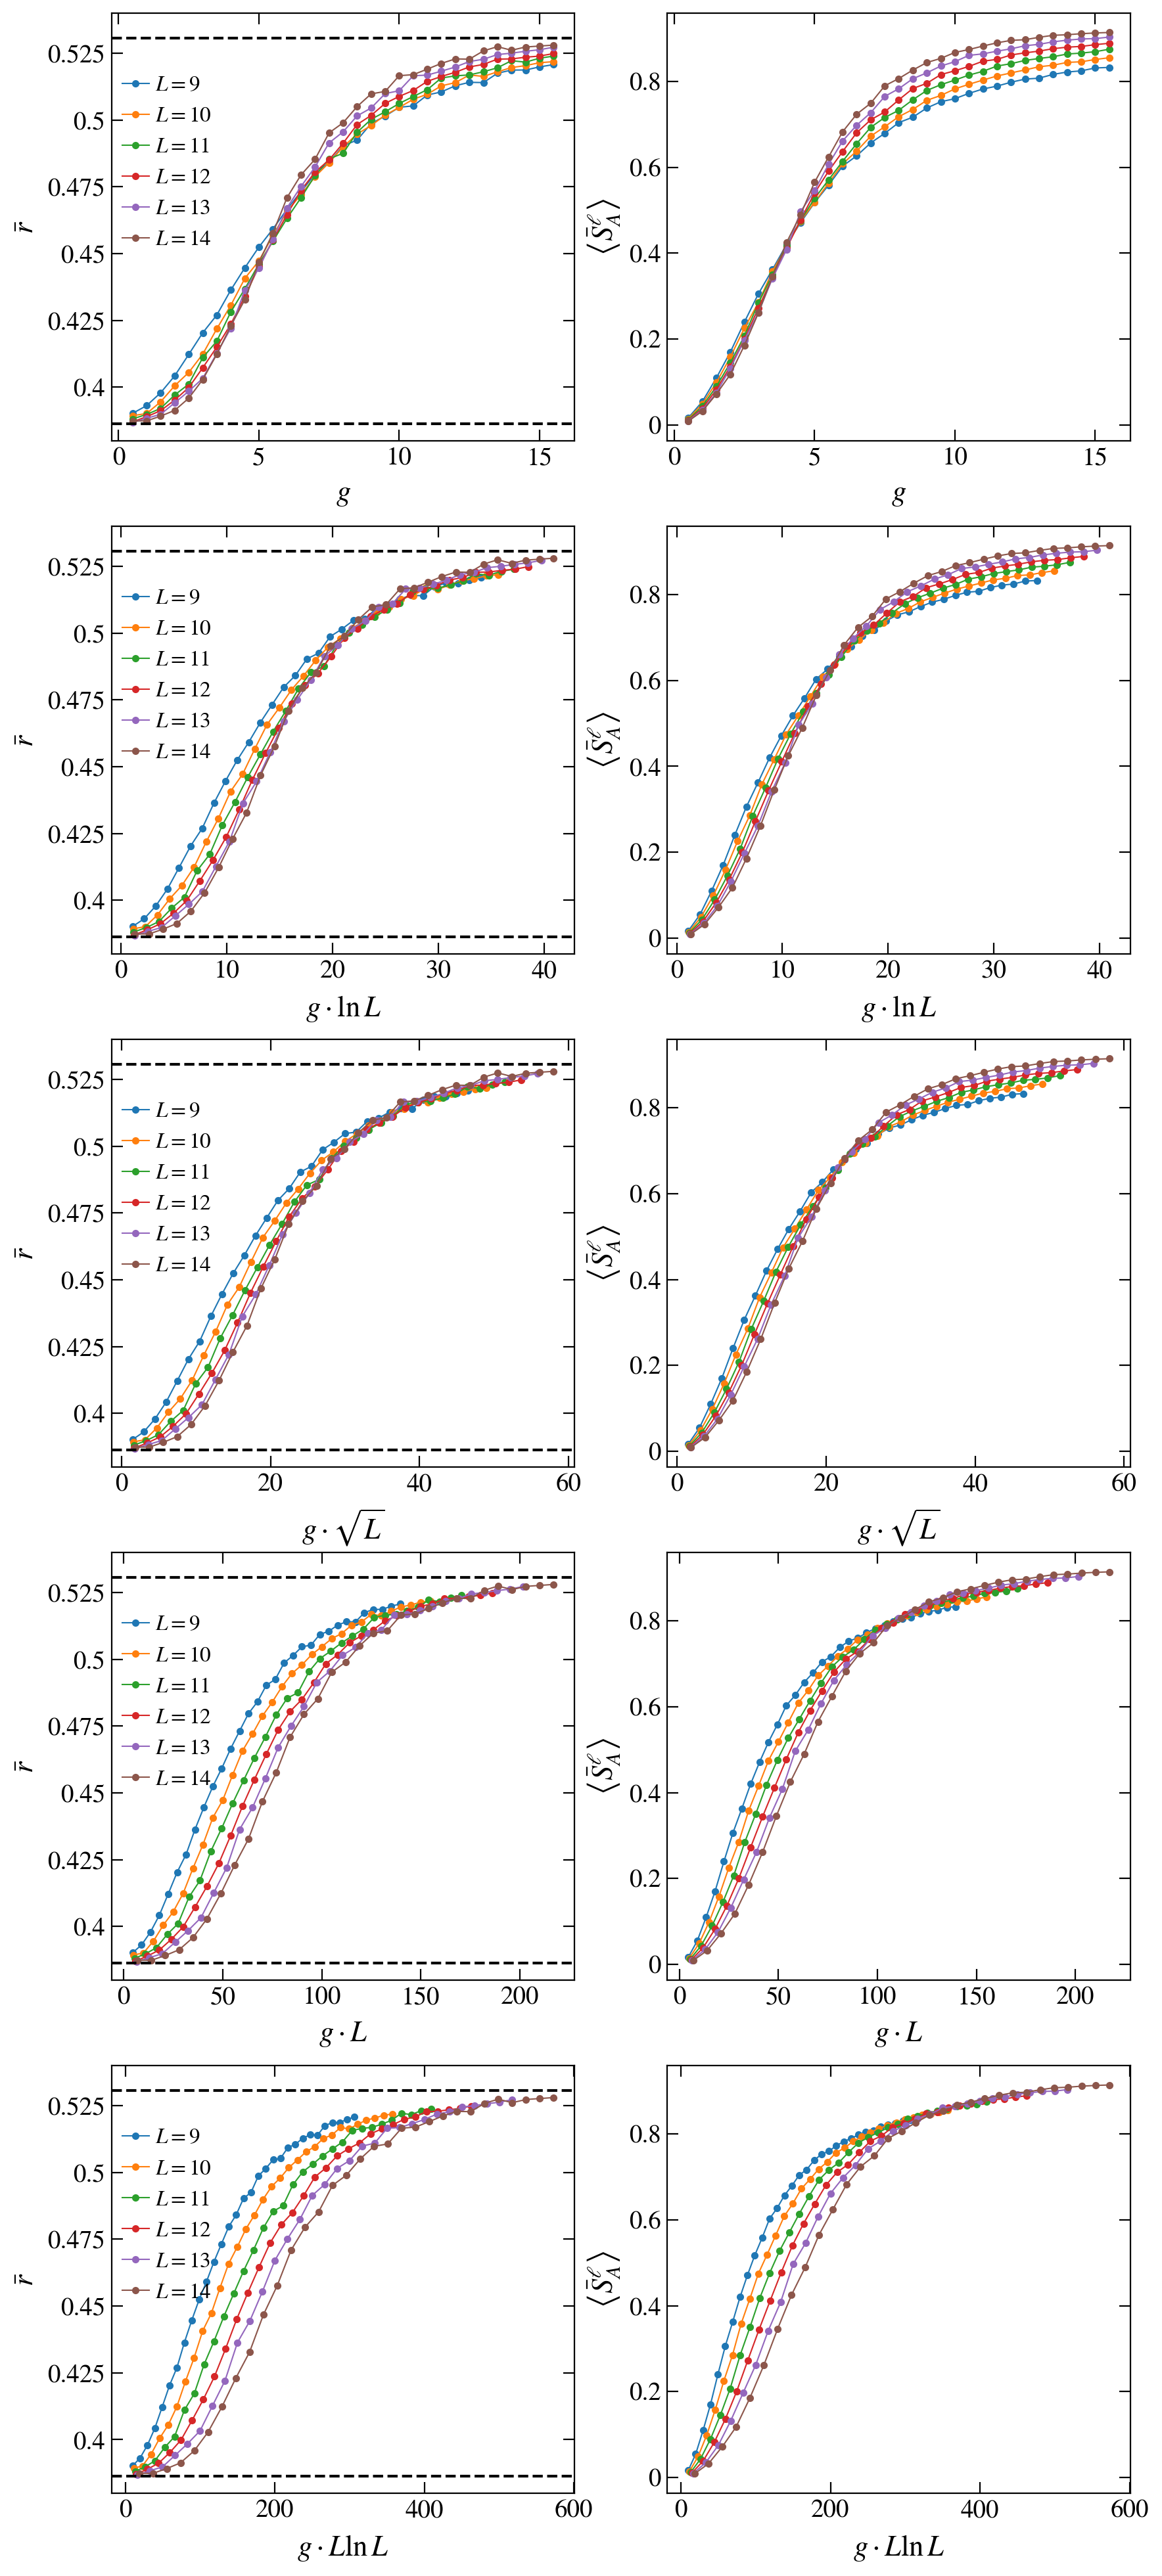

In [2]:
L=15
g=1.0


plot_gaps = 1

b = 1.5

g_vals = np.linspace(0.5, 15.5, 31)
print(g_vals)

sub_sizes = np.arange(0, L+1)

sizes = np.arange(9, 15, 1)

rescale = 0

nu = 0.1
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

rescale_func        = [lambda x, L: x, lambda x, L: x * np.log(L), lambda x, L: x * np.sqrt(L), lambda x, L: x * (L), lambda x, L: x * L * np.log(L)]
rescale_func_names  = [r"$g$",         r"$g\cdot\ln{L}$",           r"$g\cdot\sqrt{L}$",        r"$g\cdot{L}$",       r"$g\cdot L\ln{L}$"]


fig, axes = plt.subplots( nrows=len(rescale_func), ncols=2, figsize=(10,5 * len(rescale_func)), dpi = 200)
for iabc in range(len(rescale_func)):
    axis = [axes[iabc][0], axes[iabc][1]]
    perturbation = []
    gaps = []
    Ssite_av = []
    for L in sizes:
        sub_sizes = np.arange(0, L+1)
        name_out = folder + f'_L={L}.hdf5'

        if exists(name_out):
            with h5py.File(name_out, "r") as file:
                g_vals       = np.array(file.get('perurbation'))
                gap_ratio    = np.array(file.get('gap_ratio'))
                entropy      = np.array(file.get('entropy'))
                entropy_site = np.array(file.get('single_site_entropy'))
        else:
            entropy         = np.zeros((sub_sizes.size, g_vals.size))
            entropy_site    = np.zeros((sub_sizes.size, g_vals.size))
            gap_ratio       = np.zeros((g_vals.size))
            realisations    = np.zeros((g_vals.size))
            for ii, g in enumerate(g_vals):
                name = base_dir + 'Entropy/Eigenstate/' + info(L=L, g=g, ext='.hdf5')
                if not exists(name): 
                    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, g=g, ext='_beta.hdf5')
                #print(name)
                if exists(name):
                    with h5py.File(name, "r") as file:
                        energies = np.array(file.get('mean energies'))
                        ratio = np.array(file.get('gap ratio'))
                        realis = np.array(file.get('realisations'))[0]
                        realisations[ii] = realis
                        
                        dim = energies.size
                        num = frac(dim)
                        # print(dim, num)
                        E_av = np.mean(energies)
                        index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                        
                        my_min = int(index_meanE - num / 2)
                        if my_min < 0: my_min = 0;  

                        my_max = int(index_meanE + num / 2)
                        if my_max >= dim: my_max = dim

                        try:
                            if num == 500:          gap_ratio[ii] = np.array(file.get('gap ratio 500'))
                            elif num == dim//2:     gap_ratio[ii] = np.array(file.get('gap ratio D/2'))
                            else:
                                # print("otherwise")
                                gap_ratio[ii] = np.mean(ratio[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(ratio)
                            for LA in sub_sizes:
                                S = np.array(file.get('entropies'))[LA]
                                Ssite = np.array(file.get('single_site_entropy'))[LA]
                                entropy[LA][ii]         = np.mean(S[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(S)
                                entropy_site[LA][ii]    = np.mean(Ssite[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(Ssite)
                        except TypeError:
                            print(ratio)
                else:
                    print(name)

            hf = h5py.File(name_out, 'w')
            hf.create_dataset('perurbation',            g_vals.shape,           data = g_vals)
            hf.create_dataset('gap_ratio',              gap_ratio.shape,        data = gap_ratio)
            hf.create_dataset('entropy',                entropy.shape,          data = entropy)
            hf.create_dataset('single_site_entropy',    entropy_site.shape,     data = entropy_site)
            hf.create_dataset('realisations',           realisations.shape,     data = realisations)
            hf.close()
        
        ent = np.zeros(g_vals.shape)
        for ii in range(g_vals.size):
            ent[ii] = np.mean(np.transpose(entropy_site)[ii])
        
        perturbation.append( rescale_func[iabc](g_vals, L) )
        gaps.append(gap_ratio)
        Ssite_av.append(ent / page(1, L -1))
        
    for ii, L in enumerate(sizes):
        axis[0].plot(perturbation[ii], gaps[ii], marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%L)
        axis[1].plot(perturbation[ii], Ssite_av[ii], marker='o', markersize=3, lw=0.75)

    axis[0].set_ylim(0.38,0.54)
    # axis[0].set_xlim(4 * min(np.array(perturbation).flatten()), 0.8*max(np.array(perturbation).flatten()))
    # axis[1].set_xlim(4 * min(np.array(perturbation).flatten()), 0.8*max(np.array(perturbation).flatten()))
    axis[0].axhline(y=0.3863, ls='--', color='black')
    axis[0].axhline(y=0.5307, ls='--', color='black')

    # axis[1].set_ylim(0.3 + 0.1*iabc,0.9)

    fig_help.set_plot_elements(axis[0], ylabel=r"$\bar{r}$", xlabel=rescale_func_names[iabc], font_size=14, set_legend=False)
    fig_help.set_legend(axis[0], loc = 'upper left', fontsize=12, anchor=(-0.02, 0.9))

    fig_help.set_plot_elements(axis[1], ylabel=r"$\left\langle\bar{S}_A^{\ell}\right\rangle$", xlabel=rescale_func_names[iabc], font_size=14, set_legend=False)

    for ax in axis:
        ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
        ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
        ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
        ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))


fig.subplots_adjust(wspace = 0.2, hspace=0.2)

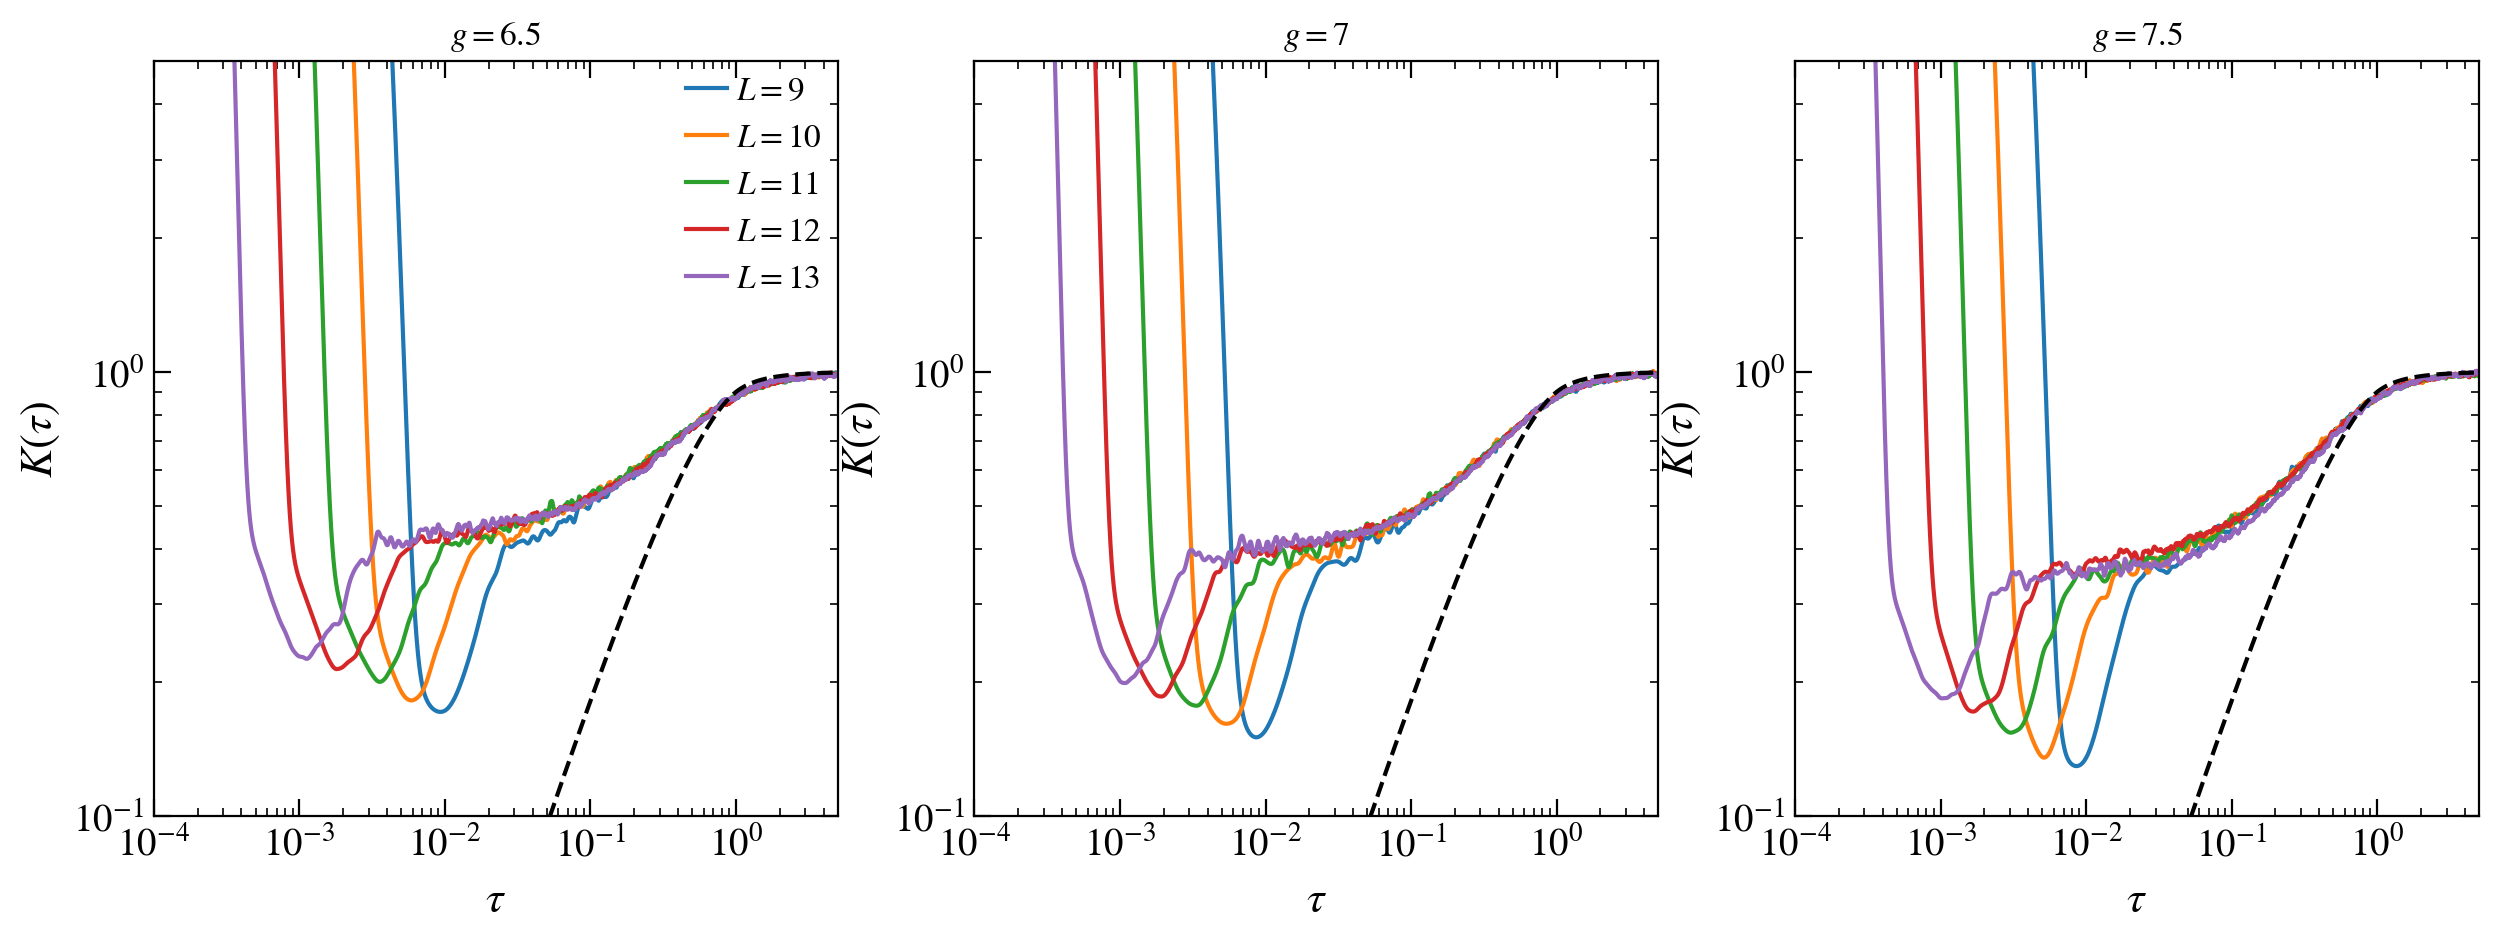

In [38]:
L=15
g=1.0

sizes = np.arange(9, 14, 1)

bucket = 20
folded = 0
running_mean = 1

g_vals = [6.5, 7., 7.5]

fig, axis = plt.subplots( nrows=1, ncols=len(g_vals), figsize=(5*len(g_vals),5), dpi = 200, sharex=True)

for ii_g, g in enumerate(g_vals):
    for L in sizes:
        name = base_dir + 'SpectralFormFactor/' + info(L=L, g=g, ext='.hdf5')
        if exists(name):
            with h5py.File(name, "r") as file:
                tHtyp = np.array(file.get('tH_typ'))[0]
                times = np.array(file.get('times_fold'))[0] / tHtyp if folded else np.array(file.get('times'))[0]
                sff = np.array(file.get('sff_fold' if folded else 'sff'))[0]
                if running_mean: sff = tools.remove_fluctuations(sff, bucket)
                
                sff = sff[bucket // 2 : -bucket // 2]
                times = times[bucket // 2 : -bucket // 2]
                axis[ii_g].plot(times, sff, label=r"$L=%d$"%L)
        else:
            print(name)
    axis[ii_g].plot(times, goe.spectral_form_factor(times), ls='--', c='k')
# axis[0].set_ylim(0.38,0.54)

# axis[1].set_ylim(0.3 + 0.1*iabc,0.9)

    fig_help.set_plot_elements(axis[ii_g], ylabel=r"$K(\tau)$", xlabel=r"$\tau$", font_size=14, set_legend=False, xscale='log', yscale='log', ylim=(1e-1,5e0), xlim=(1e-4, 5))
    axis[ii_g].set_title(r"$g=%g$"%g)
fig_help.set_legend(axis[0], loc = 'upper right', fontsize=12)

# fig_help.set_plot_elements(axis[1], ylabel=r"$\left\langle\bar{S}_A^{\ell}\right\rangle$", xlabel=rescale_func_names[iabc], font_size=14, set_legend=False)


fig.subplots_adjust(wspace = 0.2, hspace=0.2)

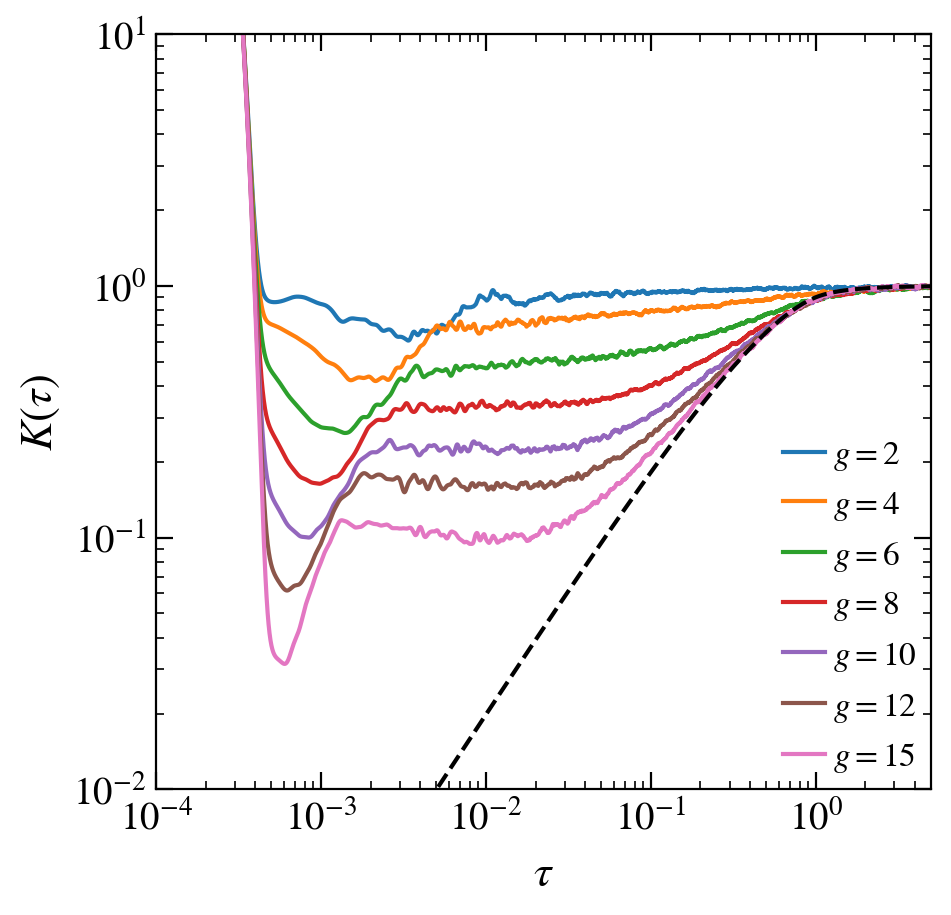

In [39]:
L=13
g=1.0

sizes = np.arange(9, 15, 1)

bucket = 20
folded = 0
running_mean = 1

g_vals = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0]

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200, sharex=True)

for ii_g, g in enumerate(g_vals):
    name = base_dir + 'SpectralFormFactor/' + info(L=L, g=g, ext='.hdf5')
    if exists(name):
        with h5py.File(name, "r") as file:
            tHtyp = np.array(file.get('tH_typ'))[0]
            times = np.array(file.get('times_fold'))[0] / tHtyp if folded else np.array(file.get('times'))[0]
            sff = np.array(file.get('sff_fold' if folded else 'sff'))[0]
            if running_mean: sff = tools.remove_fluctuations(sff, bucket)
            sff = sff[bucket // 2 : -bucket // 2]
            times = times[bucket // 2 : -bucket // 2]
            axis.plot(times, sff, label=r"$g=%g$"%g)
    else:
        print(name)
axis.plot(times, goe.spectral_form_factor(times), ls='--', c='k')
fig_help.set_plot_elements(axis, ylabel=r"$K(\tau)$", xlabel=r"$\tau$", font_size=14, set_legend=False, xscale='log', yscale='log', ylim=(1e-2,1e1), xlim=(1e-4, 5))
fig_help.set_legend(axis, loc = 'lower right', fontsize=12)

# fig_help.set_plot_elements(axis[1], ylabel=r"$\left\langle\bar{S}_A^{\ell}\right\rangle$", xlabel=rescale_func_names[iabc], font_size=14, set_legend=False)


fig.subplots_adjust(wspace = 0.2, hspace=0.2)